In [2]:
import numpy as np
import glob
import os
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [4]:
# 분산 전략 설정: GPU 수에 따라 설정
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) >= 1:
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2"])  # GPU 디바이스 번호에 맞게 수정
    print(f'사용 중인 디바이스 수: {strategy.num_replicas_in_sync}')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'기본 전략 사용 중: {strategy.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
사용 중인 디바이스 수: 3


### all landmark

In [5]:
# 메모리 매핑을 사용하여 데이터 로드
images = np.load('f_youtube_dataset_images.npy', mmap_mode='r')
landmarks = np.load('f_youtube_dataset_landmarks.npy', mmap_mode='r')

# limit개 샘플로 제한
limit = 100000
images_subset = images[:limit]
landmarks_subset = landmarks[:limit]

# 서브셋의 형태 출력
print(f'제한된 이미지 형태: {images_subset.shape}')         # 예: (limit, 224, 224, 3)
print(f'제한된 키포인트 형태: {landmarks_subset.shape}')   # 예: (limit, 68, 2)

제한된 이미지 형태: (100000, 224, 224, 3)
제한된 키포인트 형태: (100000, 68, 2)


데이터셋 배치, 프리페치 설정 완료.
배치 이미지 형태: (48, 224, 224, 3)
배치 키포인트 형태: (48, 136)


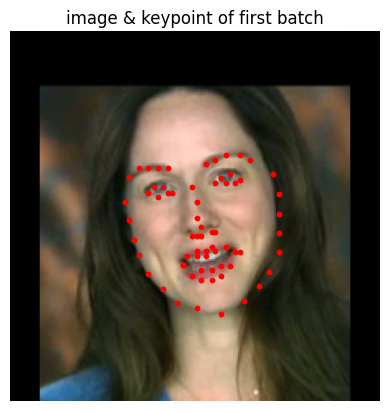

In [6]:
# 제너레이터 함수 정의 (개별 샘플 반환)
def data_generator(images, landmarks):
    num_samples = images.shape[0]
    indices = np.arange(num_samples)  # 섞지 않고 순서대로 데이터 인덱스를 가져옵니다.

    for idx in indices:
        image = images[idx].astype(np.float32) / 255.0  # 이미지 정규화 [0,1]
        landmark = landmarks[idx].astype(np.float32) / 224.0  # 키포인트 정규화 [0,1]
        landmark = landmark.reshape(-1)  # (68, 2) -> (136,)
        yield image, landmark

def generator():
    return data_generator(images, landmarks)

# TensorFlow 데이터셋 생성 (개별 샘플 반환)
output_signature = (
    tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(136,), dtype=tf.float32)
)

dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=output_signature
)

# 데이터셋 배치, 프리페치 설정 (셔플 제거)
batch_size_per_replica = 16  # 각 GPU당 배치 사이즈
batch_size = batch_size_per_replica * strategy.num_replicas_in_sync  # 전체 배치 크기

dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print('데이터셋 배치, 프리페치 설정 완료.')

# 데이터셋 형태 확인 및 시각화
for batch_images, batch_landmarks in dataset.take(1):
    print('배치 이미지 형태:', batch_images.shape)         # (48, 224, 224, 3)
    print('배치 키포인트 형태:', batch_landmarks.shape)   # (48, 136)
    
    # 시각화 예시
    image = batch_images[0].numpy()
    landmarks_plot = batch_landmarks[0].numpy() * 224.0  # 정규화된 키포인트를 원래 크기로 복원

    plt.imshow(image)
    plt.scatter(landmarks_plot[::2], landmarks_plot[1::2], c='r', s=10)
    plt.title('image & keypoint of first batch')
    plt.axis('off')
    plt.show()


In [7]:
# 학습용과 검증용 데이터셋 분리
total_samples = 100000
train_ratio = 0.8
val_ratio = 0.2

train_size = int(train_ratio * total_samples)  
val_size = total_samples - train_size        

train_ds = dataset.take(train_size // batch_size)  
val_ds = dataset.skip(train_size // batch_size).take(val_size // batch_size)  

print(f'학습 데이터셋 배치 수: {train_size // batch_size}')  
print(f'검증 데이터셋 배치 수: {val_size // batch_size}')  

학습 데이터셋 배치 수: 1666
검증 데이터셋 배치 수: 416


In [9]:
with strategy.scope():
    def create_model(input_shape=(224, 224, 3), num_keypoints=68*2):
        base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
        base_model.trainable = True  # 전이 학습을 위해 백본 고정

        x = base_model.output
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(1024, activation='relu')(x)
        outputs = layers.Dense(num_keypoints)(x)  # 회귀 문제이므로 활성화 함수 없음

        model = models.Model(inputs=base_model.input, outputs=outputs)
        return model

    # 모델 정의
    model = create_model()

    # 모델 컴파일
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mean_squared_error',
                  metrics=['mae'])

    # 모델 요약
    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [10]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import time
from tensorflow.keras import layers, models
        
# 콜백 설정
checkpoint = ModelCheckpoint('y_all_v2_adam2.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=30, verbose=1)
csv_logger = CSVLogger('y_all_training_log2.csv', append=True)

# **모델 훈련**

EPOCHS = 200

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint, reduce_lr, csv_logger]
)

Epoch 1/200
INFO:tensorflow:Collective all_reduce tensors: 162 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 162 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-11-18 08:49:09.692015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-18 08:49:09.717096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-18 08:49:09.741383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-18 08:49:13.278514: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa20e8714f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 08:49:13.278563: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-18 08:49:13.278570: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-18 08:49:13.278575: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
2024-11-18 08:49:13.288009: I ten

   1666/Unknown - 273s 123ms/step - loss: 0.0015 - mae: 0.0192

2024-11-18 08:52:49.936997: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3512740439056466812
2024-11-18 08:52:49.937076: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 119322060378767379
2024-11-18 08:52:49.937136: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13469768043747737479
2024-11-18 08:52:49.937152: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3925667839245457052
2024-11-18 08:52:49.937167: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17255628121376761475
2024-11-18 08:52:49.937178: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4619930073806673656
2024-11-18 08:52:49.937191: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it


Epoch 1: val_loss improved from inf to 0.01749, saving model to y_all_v2_adam.h5


2024-11-18 08:54:01.544955: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5996580273638569382
2024-11-18 08:54:01.545045: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14091774301233033331
2024-11-18 08:54:01.545070: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11571431234734765287
2024-11-18 08:54:01.545080: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17255628121376761475
2024-11-18 08:54:01.545091: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3367180690228819515
2024-11-18 08:54:01.545102: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2663113301191796643
2024-11-18 08:54:01.545113: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

1666/1666 [==============================] - 346s 166ms/step - loss: 0.0015 - mae: 0.0192 - val_loss: 0.0175 - val_mae: 0.1236 - lr: 0.0010
Epoch 2/200
1666/1666 [==============================] - ETA: 0s - loss: 2.0101e-04 - mae: 0.0110
Epoch 2: val_loss improved from 0.01749 to 0.00305, saving model to y_all_v2_adam.h5
1666/1666 [==============================] - 272s 163ms/step - loss: 2.0101e-04 - mae: 0.0110 - val_loss: 0.0031 - val_mae: 0.0468 - lr: 0.0010
Epoch 3/200
1666/1666 [==============================] - ETA: 0s - loss: 1.3913e-04 - mae: 0.0090
Epoch 3: val_loss did not improve from 0.00305
1666/1666 [==============================] - 272s 163ms/step - loss: 1.3913e-04 - mae: 0.0090 - val_loss: 10.5800 - val_mae: 3.0985 - lr: 0.0010
Epoch 4/200
1666/1666 [==============================] - ETA: 0s - loss: 5.5523e-04 - mae: 0.0167
Epoch 4: val_loss did not improve from 0.00305
1666/1666 [==============================] - 270s 162ms/step - loss: 5.5523e-04 - mae: 0.0167 - va

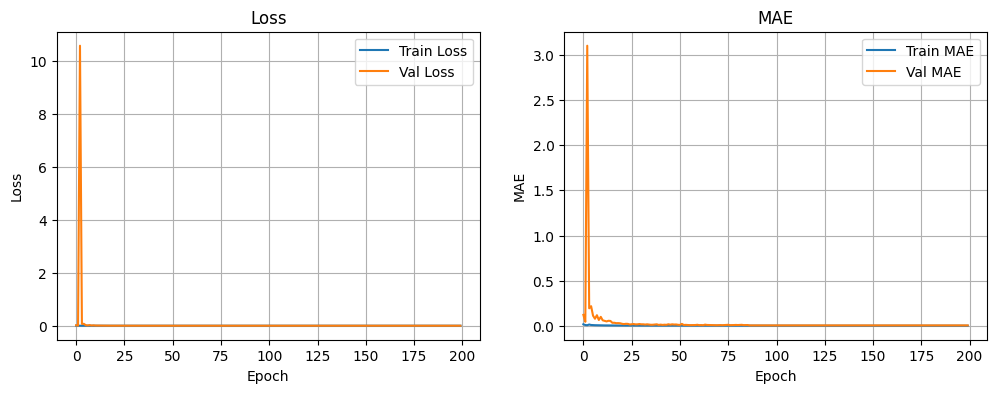

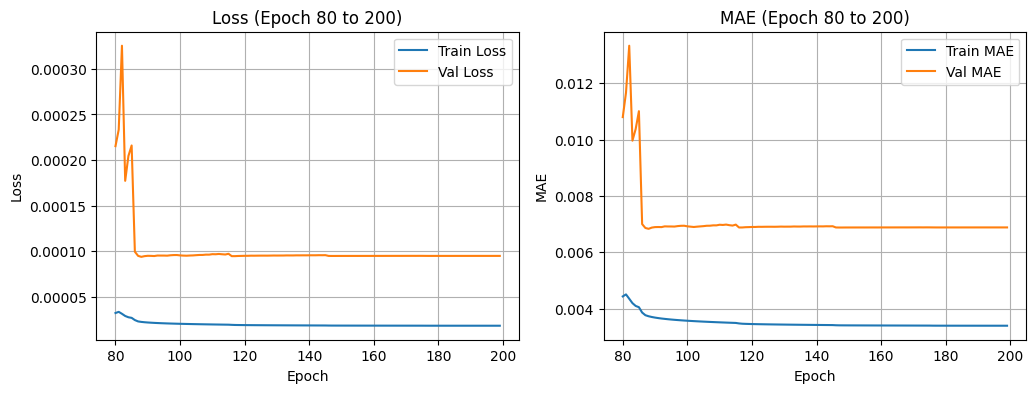

Best Epoch: 89
Minimum Validation Loss: 9.362187120132148e-05


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 경로 설정
csv_file_path = 'csv_logger/y_all_training_log2.csv'

# CSV 파일 읽기
history_df = pd.read_csv(csv_file_path)

# 에포크 수 가져오기
epochs = history_df['epoch']

# 전체 에포크 그래프 그리기
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, history_df['loss'], label='Train Loss')
plt.plot(epochs, history_df['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history_df['mae'], label='Train MAE')
plt.plot(epochs, history_df['val_mae'], label='Val MAE')
plt.legend()
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.show()

# 특정 에포크 범위 설정
start_epoch = 80  # 시작 에포크 (0부터 시작)
end_epoch = 200   # 끝 에포크 (포함하지 않음)

# 에포크 범위에 해당하는 인덱스 생성
epoch_range = (history_df['epoch'] >= start_epoch) & (history_df['epoch'] < end_epoch)

# 선택한 에포크 범위의 데이터 선택
selected_epochs = history_df['epoch'][epoch_range]
train_loss = history_df['loss'][epoch_range]
val_loss = history_df['val_loss'][epoch_range]
train_mae = history_df['mae'][epoch_range]
val_mae = history_df['val_mae'][epoch_range]

# 선택한 에포크 범위 그래프 그리기
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(selected_epochs, train_loss, label='Train Loss')
plt.plot(selected_epochs, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss (Epoch {} to {})'.format(start_epoch, end_epoch))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(selected_epochs, train_mae, label='Train MAE')
plt.plot(selected_epochs, val_mae, label='Val MAE')
plt.legend()
plt.title('MAE (Epoch {} to {})'.format(start_epoch, end_epoch))
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.show()

min_val_loss = history_df['val_loss'].min()
best_epoch = history_df[history_df['val_loss'] == min_val_loss]['epoch'].values[0] + 1  # 1을 더해줍니다.
print(f"Best Epoch: {best_epoch}")
print(f"Minimum Validation Loss: {min_val_loss}")

테스트 이미지 형태: (160399, 224, 224, 3)
테스트 키포인트 형태: (160399, 68, 2)
모델이 성공적으로 로드되었습니다.
1/1 [==============================] - 1s 923ms/step
평균 제곱 오차(MSE): 3.2594
평균 절대 오차(MAE): 1.3804
PCK@3px: 0.6912
PCK@5px: 0.9706
PCK@7px: 1.0000
PCK@10px: 1.0000


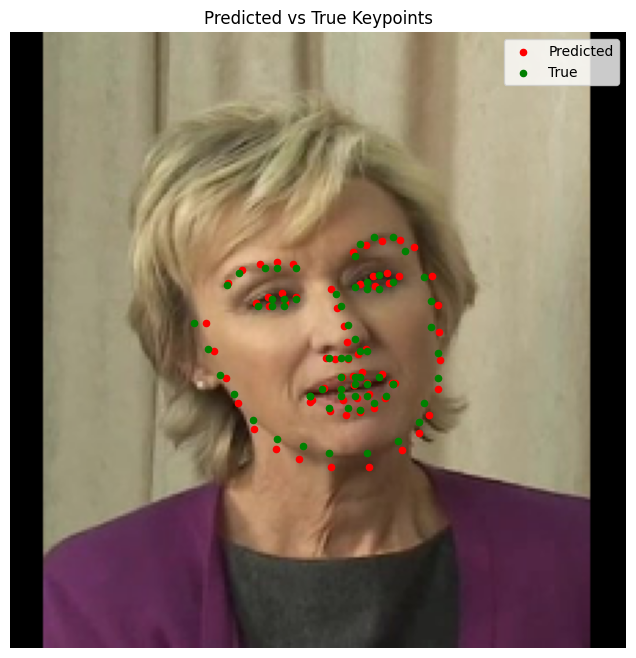

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. 데이터 로드
# 메모리 매핑을 사용하여 데이터 로드
images = np.load('f_youtube_dataset_images.npy', mmap_mode='r')
landmarks = np.load('f_youtube_dataset_landmarks.npy', mmap_mode='r')

# limit개 샘플로 제한
limit = 100000
test_images = images[limit:]
test_landmarks = landmarks[limit:]

# 서브셋의 형태 출력
print(f'테스트 이미지 형태: {test_images.shape}')         # (총 샘플 수 - limit, 224, 224, 3)
print(f'테스트 키포인트 형태: {test_landmarks.shape}')   # (총 샘플 수 - limit, 68, 2)

# 2. 모델 로드
model_path = 'model_h5/y_all_v2_adam2.h5'  # 모델 경로를 정확히 지정하세요
loaded_model = tf.keras.models.load_model(model_path)
print("모델이 성공적으로 로드되었습니다.")

# 3. 평가 함수 정의
def evaluate_single_image(model, image, true_keypoints, target_size=224, thresholds=[1, 3, 5, 7, 10]):
    """
    단일 이미지에 대해 모델의 예측을 수행하고, 평가 지표를 계산하며 시각화하는 함수.

    Parameters:
        model (tf.keras.Model): 사전 학습된 모델.
        image (np.ndarray): 평가할 이미지 (형태: (224, 224, 3)).
        true_keypoints (np.ndarray): 실제 키포인트 좌표 (1차원 배열, 길이 136).
        target_size (int): 모델의 입력 이미지 크기.
        thresholds (list): 거리 임계값들의 리스트 (픽셀 단위).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # 이미지 전처리 (이미지가 이미 (224, 224, 3)이고 [0, 255] 범위라고 가정)
    input_image = image.astype(np.float32) / 255.0
    input_image = np.expand_dims(input_image, axis=0)  # 배치 차원 추가

    # 예측
    predicted_keypoints = model.predict(input_image)[0]

    # 모델 출력이 [0,1] 범위이므로, 이를 [0, target_size]로 변환
    predicted_keypoints = predicted_keypoints * target_size

    # 실제 키포인트도 [0, target_size] 범위로 변환
    true_keypoints = true_keypoints * target_size

    # MSE 및 MAE 계산
    mse = mean_squared_error(true_keypoints, predicted_keypoints)
    mae = mean_absolute_error(true_keypoints, predicted_keypoints)

    print(f"평균 제곱 오차(MSE): {mse:.4f}")
    print(f"평균 절대 오차(MAE): {mae:.4f}")

    # 키포인트를 (num_keypoints, 2) 형태로 재구성
    num_keypoints = len(true_keypoints) // 2
    true_keypoints_reshaped = true_keypoints.reshape(-1, 2)
    predicted_keypoints_reshaped = predicted_keypoints.reshape(-1, 2)

    # 각 키포인트의 유클리드 거리 계산
    distances = np.linalg.norm(true_keypoints_reshaped - predicted_keypoints_reshaped, axis=1)

    # 여러 임계값에 대한 PCK 계산
    for threshold in thresholds:
        num_correct_keypoints = np.sum(distances <= threshold)
        pck = num_correct_keypoints / num_keypoints
        print(f"PCK@{threshold}px: {pck:.4f}")

    # 키포인트 시각화
    plt.figure(figsize=(8, 8))
    plt.imshow(image.astype(np.uint8))

    # 예측 키포인트
    plt.scatter(predicted_keypoints_reshaped[:, 0], predicted_keypoints_reshaped[:, 1], c='r', s=20, label='Predicted')
    # 실제 키포인트
    plt.scatter(true_keypoints_reshaped[:, 0], true_keypoints_reshaped[:, 1], c='g', s=20, label='True')

    plt.title('Predicted vs True Keypoints')
    plt.legend()
    plt.axis('off')
    plt.show()

# 4. 데이터셋에서 샘플 선택
sample_index = 101310  # 원하는 인덱스로 변경 가능
sample_image = test_images[sample_index]
sample_keypoints = test_landmarks[sample_index].reshape(-1) / 224.0  # [0, 1]로 정규화

# 5. 평가 및 시각화 수행
evaluate_single_image(
    loaded_model,
    sample_image,
    sample_keypoints,
    target_size=224,
    thresholds=[3, 5, 7, 10]
)
